# Anti-aliased Geological Models

This notebook gives an interactive introduction to Blockworlds, a demonstration framework for MCMC sampling from geophysics inversions that use geological models with implicit and kinematic elements.

In our paper we find it is straightforward to anti-alias interfaces that are defined _implicitly_ by some function $\phi(\mathbf{x}) = 0$; the partial volume in a voxel along the interface can be expressed, to a good approximation, as a function of the normal distance to that interface from the voxel center.  This is similar to the way interfaces are defined in packages our geologist collaborators are already working with, such as GemPy, GeoModeller, and LoopStructural.  The implicit functions these packages use are more abstract measures of geological time, rather than concrete measures like physical distance.  However, if we show that parametric anti-aliasing can work on simple models like the ones we will develop, it shouldn't be too far a step to technology that can work with more realistic 3-D geological models.

One convenient and geologically sensible way to build a volume is by composition, since in cases where multiple interfaces overlap it establishes a clear order of evaluation that resolves any interpretive ambiguities.  This is a feature of _kinematic_ models such as Noddy; LoopStructural also incorporates kinematic elements.

Let's first define an infinite-resolution geology as a composition of functions with implicitly defined interfaces; then blur out these interfaces with an anti-aliasing kernel, and evaluate on a grid for geophysics.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from blockworlds import profile_timer, DiscreteGravity
from blockworlds import baseline_tensor_mesh, survey_gridded_locations

z0 = 0.0        # height of sensors above ground
L = 1000.0      # length of one side of cubical volume in meters
NL = 15         # number of mesh cells along a side
h = L/NL        # length of one side of cubical volume in mesh cells

print("z0, L, nL, h =", z0, L, NL, h)
mesh = baseline_tensor_mesh(NL, h, centering='CCN')
survey = survey_gridded_locations(L, L, 20, 20, z0)

z0, L, nL, h = 0.0 1000.0 15 66.66666666666667


I'm going to define a sequence of events here that generates something like the graben model shown in Figures 8 and 9 of Pakyuz-Charrier et al (2018).  This has several horizontal layers and two vertical faults running through them.

Each event has its own priors so this will get pedantic pretty quickly, but when each of your arguments has physical dimensions and geometric meaning this is probably where we end up.  I've chosen these to reflect highly certain knowledge of what's going on at the surface with more uncertainty about what's going on underneath, which seems reasonable.

In [2]:
from implicit import GeoHistory, BasementEvent, StratLayerEvent, PlanarFaultEvent
from implicit import UniGaussianDist, UniLognormDist, vMFDist

# Define the geology as a list of chained events
# I'm forcing us to use keyword arguments everywhere for readability
history = GeoHistory()
# Basement:  density (g/cc)
history.add_event(
    BasementEvent(
        [('density', UniLognormDist(mean=3.0, std=0.5))]
    )
)
# Overlying stratigraphic layers:  thicknesses (m) and densities (g/cc)
history.add_event(
    StratLayerEvent(
        [('thickness', UniLognormDist(mean=350.0, std=50.0)),
        ('density', UniLognormDist(mean=2.5, std=0.1))]
    )
)
history.add_event(
    StratLayerEvent(
        [('thickness', UniLognormDist(mean=190.0, std=50.0)),
         ('density', UniLognormDist(mean=2.0, std=0.1))]
    )
)
# Faults:  anchor point r0[x,y,0] (m), normal vector spherical coordinates [theta, phi] (deg), slip (m)
history.add_event(
    PlanarFaultEvent(
        [('x0', UniGaussianDist(mean=-400.0, std=1.0)),
         ('y0', UniGaussianDist(mean=0.0, std=1.0)),
         ('nth', 'nph', vMFDist(th0=+20.0, ph0=0.0, kappa=50)),
         ('s', UniGaussianDist(mean=-220.0, std=150.0))]
    )
)
history.add_event(
    PlanarFaultEvent(
        [('x0', UniGaussianDist(mean=+400.0, std=1.0)),
         ('y0', UniGaussianDist(mean=0.0, std=1.0)),
         ('nth', 'nph', vMFDist(th0=-20.0, ph0=0.0, kappa=50)),
         ('s', UniGaussianDist(mean=+220.0, std=150.0))]
    )
)

history.serialize() = [ 2.38447657e+00  3.29241701e+02  2.23555026e+00  2.37476863e+02
  1.96325582e+00 -4.00402463e+02 -1.89731439e-01  2.21156257e+01
  2.92276676e+00 -6.07211513e+01  3.98859724e+02 -4.83125132e-01
 -3.02388504e+01  6.23815312e-01  2.77526181e+02]
history.serialize() = [   3.   350.     2.5  190.     2.  -400.     0.    20.     0.  -220.
  400.     0.   -20.     0.   220. ]
calc_gravity ran in 0.889 sec
current event: BasementEvent(density=3.0)
calc_gravity ran in 0.002 sec
current event: StratLayerEvent(thickness=350.0, density=2.5)
calc_gravity ran in 0.001 sec
current event: StratLayerEvent(thickness=190.0, density=2.0)
calc_gravity ran in 0.002 sec
current event: PlanarFaultEvent(x0=-400.0, y0=0.0, nth=20.0, nph=0.0, s=-220.0)
calc_gravity ran in 0.002 sec
current event: PlanarFaultEvent(x0=400.0, y0=0.0, nth=-20.0, nph=0.0, s=220.0)
calc_gravity ran in 0.004 sec


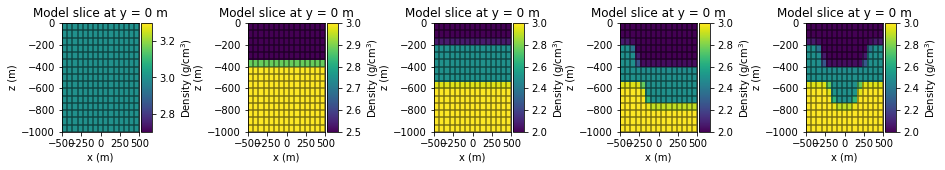

In [3]:
histpars = history.serialize()
print("history.serialize() =", histpars)

# Can also set parameters all at once -- good for initializing MCMC
history.deserialize([3.0, 350.0, 2.5, 190.0, 2.0,
                     -400.0, 0.0, +20.0, 0.0, -220.0,
                     +400.0, 0.0, -20.0, 0.0, +220.0])
histpars = history.serialize()
print("history.serialize() =", histpars)

# Define the forward model
fwdmodel = DiscreteGravity(mesh, survey, history.event_list[0])
fwdmodel.gfunc = history.event_list[0].rockprops
fwdmodel.edgemask = profile_timer(fwdmodel.calc_gravity, h)
# Show a sequence of how the model is built up
fig1 = plt.figure(figsize=(15, 2))
for m, event in enumerate(history.event_list):
    print("current event:", event)
    fwdmodel.gfunc = lambda r, h: np.array(event.rockprops(r, h))
    profile_timer(fwdmodel.calc_gravity, h)
    fwdmodel.fwd_data -= fwdmodel.edgemask * fwdmodel.voxmodel.mean()
    ax = plt.subplot(1, 5, m+1)
    fwdmodel.plot_model_slice(ax=ax)
plt.subplots_adjust(wspace=1.0)
plt.show()

The `GeoEvent` superclass contains baseline methods for initializing, serializing, and deserializing events to make them easily navigable by an API for abstract MCMC algorithms.  Each of the `GeoEvent` subclasses also contains a `rockprops` method, which for now involves only density but could be expanded to return a whole array of scalar fields of rock properties that respond to sensor.  This method is placed on a call stack for all the previous events, with the resolution proceeding as in the above figure.  Each event perturbs the field of rock properties for the previous geology, so each calls the previous event recursively to find out what it's perturbing.  Finally, each also includes elements of probabilistic models, such as a `log_prior` method that returns a prior density, and specialized MCMC proposals that respect the geological symmetries of the model.

Here's a peek at the current code for the `PlanarFaultEvent` class:

```
class PlanarFaultEvent(GeoEvent):

    _attrs = ['x0', 'y0', 'nth', 'nph', 's']

    def rockprops(self, r, h):
        assert(isinstance(self.previous_event, GeoEvent))
        # Point on fault specified in Cartesian coordinates; assume z0 = 0
        # since we're probably just including geologically observed faults
        r0 = np.array([self.x0, self.y0, 0.0])
        # Unit normal to fault ("polar vector") specified with
        # nth = elevation angle (+90 = +z, -90 = -z)
        # nph = azimuthal angle (runs counterclockwise, zero in +x direction)
        th, ph = np.radians(self.nth), np.radians(self.nph)
        n = [np.cos(th)*np.cos(ph), np.cos(th)*np.sin(ph), np.sin(th)]
        # Geology in +n direction slips relative to the background
        # Slip is positive in +z direction, in units of meters along the fault
        v = np.cross(np.cross([0, 0, 1], n), n)
        rdelt = self.s * v/l2norm(v)
        g0 = self.previous_event.rockprops(r, h)
        g1 = self.previous_event.rockprops(r + rdelt, h)
        return soft_if_then(np.dot(r-r0, n), g0, g1, h)
```

When called, `PlanarFault.rockprops()` first works out the placement and kinematics of the fault; then evaluates the base geology on either side of the fault; and finally performs the anti-aliasing step.  The underlying geological process is always evaluated at full resolution at each stage, and the recursive call structure ensures that each geological feature is evaluated in the correct "lab frame" coordinates before anti-aliasing.  Only the voxels along each interface need to be anti-aliased, which helps keep the evaluation quick.

Let's scan some posterior slices from these models now:

In [4]:
from riemann import Sampler, Model
from riemann.proposals.randomwalk import AdaptiveMetropolisRandomWalk as AMRW

class GeoModel(Model):
    
    def __init__(self, history, fwdmodel, dsynth, sigdata):
        # Set baseline attributes
        self.history = history
        self.fwdmodel = fwdmodel
        self.dsynth = dsynth
        self.sigdata = sigdata
        # Set forward model to represent history
        self.fwdmodel.gfunc = history.rockprops
        # Turn full anti-aliasing on; match h to grid resolution
        mesh = self.fwdmodel.mesh
        self.h = np.exp(np.mean(np.log([mesh.hx, mesh.hy, mesh.hz])))
        
    def log_likelihood(self, theta):
        # Load this parameter vector into the history and calculate gravity
        self.history.deserialize(theta)
        dpred = fwdmodel.calc_gravity(self.h)
        resids = dpred - dsynth
        resids = resids - resids.mean()
        # Independent Gaussian likelihood with variance sigdata**2
        return -0.5*np.sum(resids**2/self.sigdata**2 + np.log(2*np.pi*sigdata**2))

    def log_prior(self, theta):
        # Load this parameter vector into the history and calculate prior density
        self.history.deserialize(theta)
        return history.logprior()

In [5]:
# Make some synthetic data
data0 = fwdmodel.calc_gravity(h)
np.random.seed(413)
sigrel = 0.05
sigdata = sigrel*np.std(data0)
epsilon = sigdata*np.random.normal(size=data0.shape)
dsynth = data0 + epsilon

# Generate a GeoModel
model = GeoModel(history, fwdmodel, dsynth, sigdata)

def run_grid(model, p1_vals, p2_vals, p1_idx, p2_idx):
    origpars = model.history.serialize()
    grid_vals = [ ]
    for p1i in p1_vals:
        for p2i in p2_vals:
            theta = np.array(origpars)
            theta[p1_idx], theta[p2_idx] = p1i, p2i
            grid_vals.append([p1i, p2i, model.log_posterior(theta)])
    model.history.deserialize(origpars)
    grid_vals = np.array(grid_vals).T.reshape(3, len(p1_vals), len(p2_vals))
    return grid_vals

def show_contours(xg, yg, Lg, p1_vals, p2_vals, p1_0, p2_0):
    levels = 10**np.arange(-6,0.1)
    levels = np.log(10)*np.arange(-6,0.1)
    # plt.contourf(xg, yg, np.exp(Lg - Lg.max()), levels=levels)
    plt.contourf(xg, yg, Lg - Lg.max(), levels=levels)
    plt.colorbar()
    ax = plt.gca()
    ax.set_xlim(p1_vals.min(), p1_vals.max())
    ax.set_ylim(p2_vals.min(), p2_vals.max())

In [6]:
def vet_slice(model, z1_idx, z2_idx, zdelt1, zdelt2, Nz):
    histpars = np.array(model.history.serialize())
    z1_0, z2_0 = histpars[z1_idx], histpars[z2_idx]
    z1_vals = np.linspace(z1_0-0.5*zdelt1, z1_0+0.5*zdelt1, Nz)
    z2_vals = np.linspace(z2_0-0.5*zdelt2, z2_0+0.5*zdelt2, Nz)
    xg, yg, Lg = profile_timer(run_grid, model, z1_vals, z2_vals, z1_idx, z2_idx)
    show_contours(xg, yg, Lg, z1_vals, z2_vals, z1_0, z2_0)

run_grid ran in 3.405 sec
run_grid ran in 3.366 sec
run_grid ran in 3.363 sec


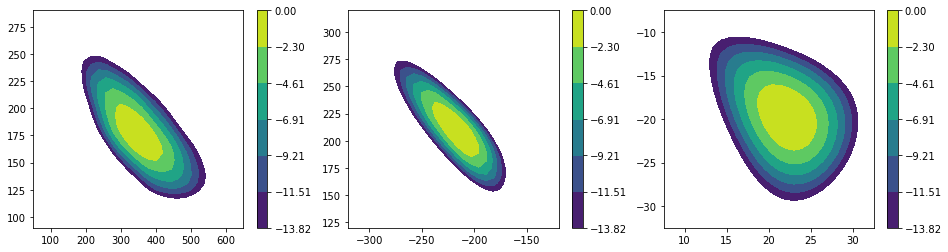

In [7]:
Nz = 30
fig = plt.figure(figsize=(16, 4))
plt.subplot(131)
vet_slice(model,  1,  3, 600.0, 200.0, Nz)   # widths of layers on top of basement
plt.subplot(132)
vet_slice(model,  9, 14, 200.0, 200.0, Nz)   # the two fault displacements
plt.subplot(133)
vet_slice(model,  7, 12,  25.0,  25.0, Nz)   # the two fault elevation angles
plt.show()

These look very reasonable!  But we can also turn anti-aliasing off, and show what happens:

run_grid ran in 3.429 sec
run_grid ran in 3.213 sec
run_grid ran in 3.126 sec


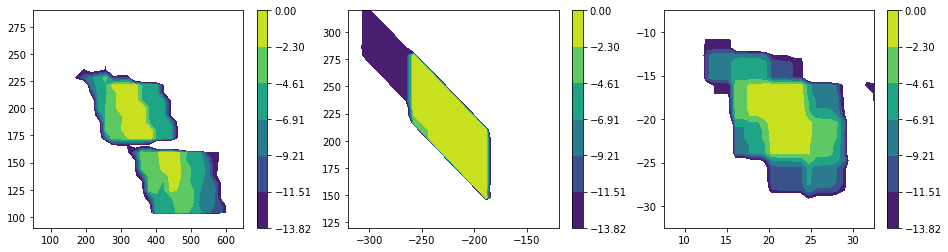

In [8]:
Nz = 30
model.h = 0.001*h
fig = plt.figure(figsize=(16, 4))
plt.subplot(131)
vet_slice(model,  1,  3, 600.0, 200.0, Nz)   # widths of layers on top of basement
plt.subplot(132)
vet_slice(model,  9, 14, 200.0, 200.0, Nz)   # the two fault displacements
plt.subplot(133)
vet_slice(model,  7, 12,  25.0,  25.0, Nz)   # the two fault elevation angles
model.h = h
plt.show()

## Sampling with Riemann

Let's try to sample the posterior of this model now using MCMC.  We'll use the adaptive Metropolis random walk (AMRW; Haario et al. 2001), as is used in the paper.  With anti-aliasing in place we could use more advanced samplers that use derivative information, like Hamiltonian Monte Carlo; we didn't use these in our paper since this wouldn't permit direct comparison with the aliased posterior, where the derivative is zero almost everywhere.

In [9]:
from riemann import Sampler, Model
from riemann.proposals.randomwalk import AdaptiveMetropolisRandomWalk as AMRW

Npars = len(histpars)
Nsamp = 100000
stepsizes = np.array([0.1, 100, 0.01, 100, 0.01,
                      1.0, 1.0, 1.0, 1.0, 100,
                      1.0, 1.0, 1.0, 1.0, 100])
model.history.set_to_prior_draw()
proposal = AMRW(0.1*np.diag(stepsizes), 100, marginalize=False)
sampler = Sampler(model, proposal, np.array(histpars))
profile_timer(sampler.run, Nsamp)
chain = np.array(sampler._chain_thetas)
model.history.deserialize(sampler._chain_thetas[0])
print("chain.mean =", np.mean(chain, axis=0))
print("chain.std  =", np.std(chain, axis=0))
print("acceptance fraction =", np.mean(chain[1:]-chain[:-1] != 0))

run ran in 375.390 sec
chain.mean = [ 2.92618880e+00  3.54160831e+02  2.51008987e+00  1.58849760e+02
  1.98617985e+00 -3.99975645e+02 -1.37558753e-03  1.84016988e+01
 -9.55723472e-02 -2.10127087e+02  4.00002495e+02 -1.84434818e-02
 -1.96933860e+01 -2.19788103e-01  1.96637837e+02]
chain.std  = [2.99091431e-01 4.90846478e+01 8.62750288e-02 2.75357968e+01
 4.23465290e-02 1.01320792e+00 9.80941200e-01 4.89534142e+00
 1.55463849e+00 5.86173476e+01 9.85687453e-01 9.98509636e-01
 5.01238881e+00 1.72368432e+00 5.56987167e+01]
acceptance fraction = 0.17598


In [10]:
vnames = np.concatenate([event._pars for event in model.history.event_list])
vmean = np.mean(chain, axis=0)
vstd = np.std(chain, axis=0)

for i in range(len(vnames)):
    print("{:<10} {:10.1f} +/- {:10.1f}".format(vnames[i], vmean[i], vstd[i]))

density           2.9 +/-        0.3
thickness       354.2 +/-       49.1
density           2.5 +/-        0.1
thickness       158.8 +/-       27.5
density           2.0 +/-        0.0
x0             -400.0 +/-        1.0
y0               -0.0 +/-        1.0
nth              18.4 +/-        4.9
nph              -0.1 +/-        1.6
s              -210.1 +/-       58.6
x0              400.0 +/-        1.0
y0               -0.0 +/-        1.0
nth             -19.7 +/-        5.0
nph              -0.2 +/-        1.7
s               196.6 +/-       55.7


In [11]:
from scipy.stats import gaussian_kde

def vet_slice_2(z1_idx, z2_idx, zdelt1, zdelt2, Nz):
    z1_0, z2_0 = histpars[z1_idx], histpars[z2_idx]
    z1g = np.linspace(z1_0-0.5*zdelt1, z1_0+0.5*zdelt1, Nz)
    z2g = np.linspace(z2_0-0.5*zdelt2, z2_0+0.5*zdelt2, Nz)
    x, y = chain[:,z1_idx], chain[:,z2_idx]
    xy = np.vstack([x,y])
    kde = gaussian_kde(xy)
    # th = np.repeat(chain[0,:], len(chain)).reshape(len(chain), -1)
    # kde = gaussian_kde(th)
    xg, yg = np.meshgrid(z1g, z2g)
    xyg = np.array([xg, yg]).reshape(2,-1)
    zg = kde(xyg).reshape(xg.shape)
    # thg = np.repeat(chain[0,:], len(xg)).reshape(len(xg), -1)
    # zg = kde(thg).reshape(xg.shape)
    levels = np.log(10)*np.arange(-6,0.1)
    plt.contourf(xg, yg, np.log(zg + 1e-12) - np.log(zg.max()), levels=levels)
    plt.colorbar()

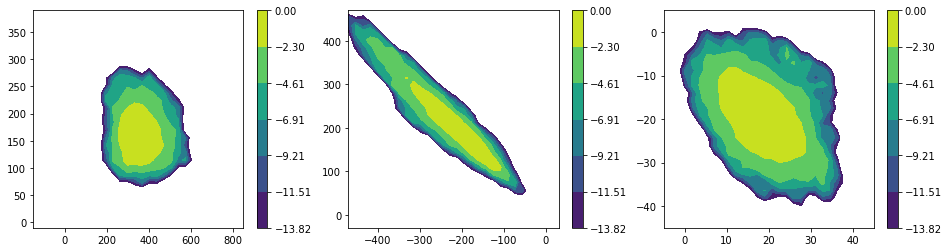

In [12]:
Nz = 30
fig = plt.figure(figsize=(16, 4))
plt.subplot(131)
vet_slice_2( 1,  3, 1000.0, 400.0, Nz)   # widths of layers on top of basement
plt.subplot(132)
vet_slice_2( 9, 14, 500.0, 500.0, Nz)   # the two fault displacements
plt.subplot(133)
vet_slice_2( 7, 12,  50.0,  50.0, Nz)   # the two fault elevation angles
plt.show()

This is the _marginal_ posterior (a distribution of samples projected onto the planes shown), while the earlier contour plots were showing the _conditional_ posterior (slices through the posterior with all the other variables fixed).  So it makes sense that they might not look exactly the same.



In [13]:
import emcee
tau = emcee.autocorr.integrated_time(chain)
print("chain.shape =", chain.shape)
print("tau =", tau)
print("ess =", len(chain)/tau)

chain.shape = (100001, 15)
tau = [126.82798278]
ess = [788.47741489]


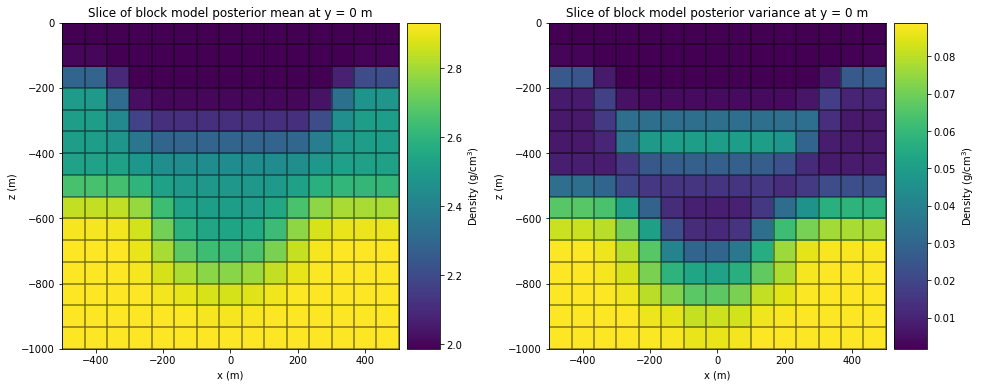

In [14]:
thin = int(tau)
r = fwdmodel.mesh.gridCC
geoshape = fwdmodel.gfunc(r, h).shape
geovox1 = np.zeros(geoshape)
geovox2 = np.zeros(geoshape)
Nthin = len(chain[::thin])
for theta in chain[::thin]:
    history.deserialize(theta)
    g = fwdmodel.gfunc(r, h)
    geovox1 += g
    geovox2 += g*g
gmu = geovox1/Nthin
gvar = geovox2/Nthin - gmu*gmu

plt.figure(figsize=(16,6))
ax1 = plt.subplot(1,2,1)
fwdmodel.voxmodel = gmu
fwdmodel.plot_model_slice(ax=ax1)
plt.title("Slice of block model posterior mean at y = 0 m")
ax2 = plt.subplot(1,2,2)
fwdmodel.voxmodel = gvar
fwdmodel.plot_model_slice(ax=ax2)
plt.title("Slice of block model posterior variance at y = 0 m")
plt.show()

In [15]:
def gelman_rubin(data):
    """
    Apply Gelman-Rubin convergence diagnostic to a bunch of chains.
    :param data: np.array of shape (Nchains, Nsamples, Npars)
    """
    Nchains, Nsamples, Npars = data.shape
    B_on_n = data.mean(axis=1).var(axis=0)      # variance of in-chain means
    W = data.var(axis=1).mean(axis=0)           # mean of in-chain variances

    # simple version, as in Obsidian
    sig2 = (Nsamples/(Nsamples-1))*W + B_on_n
    Vhat = sig2 + B_on_n/Nchains
    Rhat = Vhat/W

    # advanced version that accounts for ndof
    m, n = np.float(Nchains), np.float(Nsamples)
    si2 = data.var(axis=1)
    xi_bar = data.mean(axis=1)
    xi2_bar = data.mean(axis=1)**2
    var_si2 = data.var(axis=1).var(axis=0)
    allmean = data.mean(axis=1).mean(axis=0)
    cov_term1 = np.array([np.cov(si2[:,i], xi2_bar[:,i])[0,1]
                          for i in range(Npars)])
    cov_term2 = np.array([-2*allmean[i]*(np.cov(si2[:,i], xi_bar[:,i])[0,1])
                          for i in range(Npars)])
    var_Vhat = ( ((n-1)/n)**2 * 1.0/m * var_si2
             +   ((m+1)/m)**2 * 2.0/(m-1) * B_on_n**2
             +   2.0*(m+1)*(n-1)/(m*n**2)
                    * n/m * (cov_term1 + cov_term2))
    df = 2*Vhat**2 / var_Vhat
    print("gelman_rubin(): var_Vhat = {}".format(var_Vhat))
    print("gelman_rubin(): df = {}".format(df))
    Rhat *= df/(df-2)

    return Rhat

In [16]:
# Generate four identical chains to calculate Gelman-Rubin from
Nsamp = 100000
import pickle
pklfname = "implicit_chains_h1.pkl"
try:
    print("Trying to load chains from {}".format(pklfname))
    with open(pklfname,"rb") as pklfile:
        chains_h1 = pickle.load(pklfile)
except:
    print("pickle load failed -- regenerating chains")
    chains_h1 = [ ]
    for i in range(4):
        model.history.set_to_prior_draw()
        proposal = AMRW(0.1*np.diag(stepsizes), 100, marginalize=False)
        sampler_i = Sampler(model, proposal, np.array(model.history.serialize()))
        profile_timer(sampler_i.run, Nsamp)
        chains_h1.append(np.array(sampler_i._chain_thetas))
    chains_h1 = np.array(chains_h1)
    with open(pklfname, 'wb') as pklfile:
        pickle.dump(chains_h1, pklfile)
print("chains.shape =", chains_h1.shape)
print("gelman_rubin(): Rhat = {}".format(gelman_rubin(chains_h1)))

Trying to load chains from implicit_chains_h1.pkl
pickle load failed -- regenerating chains
run ran in 364.360 sec
run ran in 356.594 sec
run ran in 378.073 sec
run ran in 363.789 sec
chains.shape = (4, 100001, 15)
gelman_rubin(): var_Vhat = [4.24641094e-05 2.10753947e+04 2.33938368e-07 6.40531390e+03
 1.64526232e-08 1.97506316e-04 9.97430421e-04 4.43826438e+00
 1.09163592e-01 5.42580406e+06 2.13332089e-03 5.71380816e-05
 3.44195047e+00 1.11110740e-02 4.34133975e+06]
gelman_rubin(): df = [4.44643166e+02 5.68369347e+02 8.24723396e+02 2.89117345e+02
 5.44855780e+02 1.02084365e+04 1.98424486e+03 3.22926621e+02
 1.34686436e+02 1.42185797e+01 9.45276024e+02 3.55945937e+04
 5.06043880e+02 1.50572571e+03 1.43637552e+01]
gelman_rubin(): Rhat = [1.02071843 1.01574958 1.02115661 1.04571281 1.02783199 1.00434918
 1.00417186 1.02706297 1.02081743 1.25043419 1.00350687 1.00415379
 1.01355838 1.00210225 1.2425222 ]


In [17]:
pklfname = "implicit_chains_h0.pkl"
try:
    print("Trying to load chains from {}".format(pklfname))
    with open(pklfname,"rb") as pklfile:
        chains_h0 = pickle.load(pklfile)
except:
    print("pickle load failed -- regenerating chains")
    chains_h0 = [ ]
    for i in range(4):
        model.h = 0.001*h
        model.history.set_to_prior_draw()
        proposal = AMRW(0.1*np.diag(stepsizes), 100, marginalize=False)
        sampler_i = Sampler(model, proposal, np.array(model.history.serialize()))
        profile_timer(sampler_i.run, Nsamp)
        model.h = 1.0*h
        chains_h0.append(np.array(sampler_i._chain_thetas))
    chains_h0 = np.array(chains_h0)
    with open(pklfname, 'wb') as pklfile:
        pickle.dump(chains_h0, pklfile)
print("chains_h0.shape =", chains_h0.shape)
print("gelman_rubin(): Rhat = {}".format(gelman_rubin(chains_h0[:,int(Nsamp/5):,:])))

Trying to load chains from implicit_chains_h0.pkl
pickle load failed -- regenerating chains
run ran in 351.294 sec
run ran in 362.323 sec
run ran in 378.356 sec
run ran in 371.378 sec
chains_h0.shape = (4, 100001, 15)
gelman_rubin(): var_Vhat = [4.86772774e-03 4.78368509e+04 8.48467137e-07 5.78406588e+05
 1.42865707e-05 1.22458954e-03 1.38499830e-04 8.59310923e+00
 8.50931423e-01 2.39294591e+07 6.67831737e-04 1.33181313e-03
 2.94475269e+00 1.94021910e-01 8.49584787e+06]
gelman_rubin(): df = [1.12376377e+01 2.56049295e+02 1.14186291e+02 1.10776894e+01
 5.34861633e+00 1.84041037e+03 1.46954763e+04 3.50682500e+02
 3.18654347e+01 6.57702310e+00 3.14244163e+03 1.42635814e+03
 8.05467075e+02 1.28967942e+02 8.26889471e+00]
gelman_rubin(): Rhat = [3.18257901 1.00936708 1.1298638  3.28195185 3.684721   1.00647581
 1.00064865 1.07866537 1.07434853 5.55831668 1.00663059 1.00375747
 1.04569873 1.02073486 2.96134159]


In [18]:
print("R0/R1 =", gelman_rubin(chains_h0)/gelman_rubin(chains_h1[:,int(Nsamp/5):,:]))

gelman_rubin(): var_Vhat = [8.08505679e-03 1.08251972e+04 7.74810649e-07 6.84817180e+05
 1.88736960e-05 3.64095697e-04 2.82781446e-04 4.12392955e+00
 8.97728383e-01 3.78720979e+07 8.10643584e-04 5.28854435e-03
 1.78946337e+02 1.43355124e+00 7.28843636e+06]
gelman_rubin(): df = [1.00347139e+01 1.22288627e+03 1.76941494e+02 1.03200880e+01
 4.82982299e+00 5.89264972e+03 7.19744739e+03 5.98401683e+02
 3.66806100e+01 6.02483341e+00 2.40425982e+03 4.09129619e+02
 2.57244950e+01 2.49501489e+01 9.30256948e+00]
gelman_rubin(): var_Vhat = [1.35761106e-05 2.50928965e+03 1.37077090e-08 3.06645625e+02
 3.93522338e-10 4.47697183e-05 4.07488771e-04 2.75236965e-01
 3.93406416e-03 6.78914905e+03 1.72181867e-04 2.37901055e-04
 3.62083733e-01 1.42580085e-03 1.89068092e+03]
gelman_rubin(): df = [ 1078.18924197  4748.25878974  9441.33292211  3700.32228013
 15674.36024911 42631.07490312  4523.36643167  4536.24042985
  2730.61356669  3120.24920586 10503.62252932  8156.1271392
  4061.12547044 11194.08377031  

In [19]:
vmean_h0 = np.mean(chains_h0.reshape(-1, len(vnames)), axis=0)
vstd_h0 = np.std(chains_h0.reshape(-1, len(vnames)), axis=0)
vmean_h1 = np.mean(chains_h1.reshape(-1, len(vnames)), axis=0)
vstd_h1 = np.std(chains_h1.reshape(-1, len(vnames)), axis=0)

for i in range(len(vnames)):
    print("{:<10} {:10.1f} +/- {:10.1f}   {:10.1f} +/- {:10.1f}"
          .format(vnames[i], vmean_h0[i], vstd_h0[i], vmean_h1[i], vstd_h1[i]))

density           2.8 +/-        0.4          2.9 +/-        0.3
thickness       352.2 +/-       50.6        351.7 +/-       49.4
density           2.5 +/-        0.1          2.5 +/-        0.1
thickness       148.2 +/-       40.5        156.4 +/-       30.9
density           2.0 +/-        0.1          2.0 +/-        0.0
x0             -400.0 +/-        1.0       -400.0 +/-        1.0
y0                0.1 +/-        1.0          0.1 +/-        1.0
nth              17.7 +/-        5.9         18.2 +/-        5.2
nph              -0.1 +/-        2.0         -0.2 +/-        1.6
s              -173.9 +/-       95.2       -227.4 +/-       78.3
x0              400.0 +/-        1.0        400.0 +/-        1.0
y0               -0.1 +/-        1.0          0.0 +/-        1.0
nth             -17.7 +/-        6.8        -19.8 +/-        5.4
nph              -0.4 +/-        2.0         -0.3 +/-        1.7
s               188.9 +/-       72.8        213.4 +/-       74.2


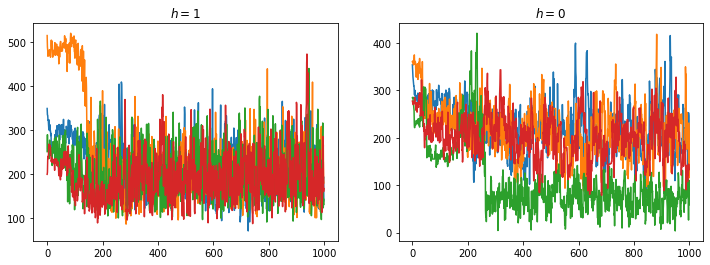

In [20]:
# Let's look at the mixing of some of these terrible chains
def plot_gr_traces(ipar):
    ipar, Npl = 14, Nsamp
    fig = plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(chains_h1[:,:Npl:100,ipar].T)
    plt.title("$h = 1$")
    plt.subplot(1,2,2)
    plt.plot(chains_h0[:,:Npl:100,ipar].T)
    plt.title("$h = 0$")
    plt.show()
plot_gr_traces(14)

In [21]:
# Re-evaluate using 20k burn-in
print("gelman_rubin(): Rhat = {}".format(gelman_rubin(chains_h1[:,int(Nsamp/5):,:])))
print("gelman_rubin(): Rhat = {}".format(gelman_rubin(chains_h0[:,int(Nsamp/5):,:])))

gelman_rubin(): var_Vhat = [1.35761106e-05 2.50928965e+03 1.37077090e-08 3.06645625e+02
 3.93522338e-10 4.47697183e-05 4.07488771e-04 2.75236965e-01
 3.93406416e-03 6.78914905e+03 1.72181867e-04 2.37901055e-04
 3.62083733e-01 1.42580085e-03 1.89068092e+03]
gelman_rubin(): df = [ 1078.18924197  4748.25878974  9441.33292211  3700.32228013
 15674.36024911 42631.07490312  4523.36643167  4536.24042985
  2730.61356669  3120.24920586 10503.62252932  8156.1271392
  4061.12547044 11194.08377031  8984.12714251]
gelman_rubin(): Rhat = [1.00265909 1.00087072 1.00058769 1.00163621 1.0029498  1.00250531
 1.00292404 1.00368135 1.00156537 1.00215293 1.0002812  1.00138291
 1.00138397 1.00112972 1.00089742]
gelman_rubin(): var_Vhat = [4.86772774e-03 4.78368509e+04 8.48467137e-07 5.78406588e+05
 1.42865707e-05 1.22458954e-03 1.38499830e-04 8.59310923e+00
 8.50931423e-01 2.39294591e+07 6.67831737e-04 1.33181313e-03
 2.94475269e+00 1.94021910e-01 8.49584787e+06]
gelman_rubin(): df = [1.12376377e+01 2.56049